In [1]:
import jax
import jax.numpy as jnp
import networkx as nx
from typing import NamedTuple

In [2]:
class Node(NamedTuple):
    index: jnp.int32
    type: jnp.int32
    enabled: jnp.bool_

class ActivationState(NamedTuple):
    activations: jnp.ndarray
    activated_nodes: jnp.ndarray
    activation_counts: jnp.ndarray

class Network(NamedTuple):
    nodes: list[Node]
    edges: jnp.ndarray
    senders: jnp.ndarray
    receivers: jnp.ndarray

    @property
    def n_nodes(self) -> int:
        return len(self.nodes.index)

    @property
    def input_nodes(self) -> int:
        return jnp.where(self.nodes.type == 1)[0]

    @property
    def n_inputs(self) -> int:
        return len(self.input_nodes)

    @property
    def n_required_activations(self) -> dict:
        """
        Returns the number of required activations for each
        non-input node.
        """
        unique, counts = jnp.unique(self.receivers, return_counts=True)
        return jnp.zeros(self.n_nodes).at[unique].set(counts)


def init_activations(
    net: Network, inputs: jnp.ndarray
) -> tuple[jnp.ndarray, jnp.ndarray]:
    activations = jnp.zeros(net.n_nodes).at[: net.n_inputs].set(inputs)
    activated_nodes = jnp.int32(activations > 0)
    return activations, activated_nodes

In [3]:
def plot_network(net: Network) -> None:
    def convert_jraph_to_networkx_graph(net: Network) -> nx.Graph:
        n_nodes = len(net.nodes)
        n_edges = len(net.edges)

        nx_graph = nx.DiGraph()
        if net.nodes is None:
            for n in range(n_nodes[0]):
                nx_graph.add_node(n)
        else:
            for n in range(n_nodes):
                nx_graph.add_node(n, node_feature=net.nodes[n])
        if net.edges is None:
            for e in range(n_edges):
                nx_graph.add_edge(int(net.senders[e]), int(net.receivers[e]))
        else:
            for e in range(n_edges):
                nx_graph.add_edge(
                    int(net.senders[e]),
                    int(net.receivers[e]),
                    edge_feature=net.edges[e],
                )
        return nx_graph

    nx_graph = convert_jraph_to_networkx_graph(net)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color="yellow")

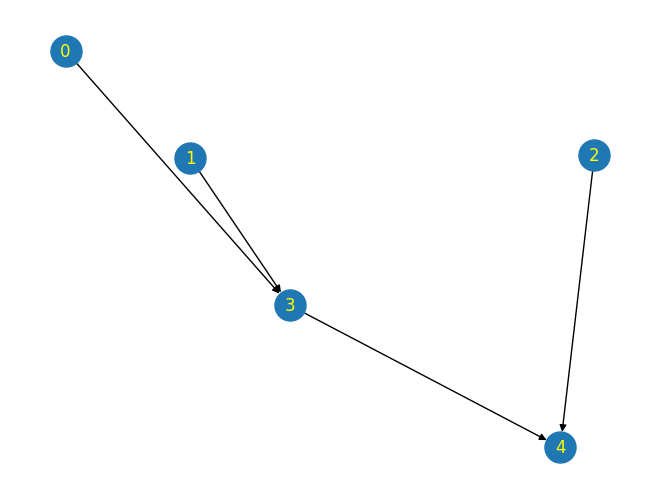

In [4]:
n_nodes = 5
nodes = jax.vmap(Node)(
    index=jnp.arange(n_nodes),
    type=jnp.array([1, 1, 1, 2, 3]),
    enabled=jnp.ones(n_nodes),
)
net = Network(
    nodes,
    edges=jnp.ones(n_nodes - 1),
    senders=jnp.array([0, 1, 2, 3]),
    receivers=jnp.array([3, 3, 4, 4]),
)
plot_network(net)

In [5]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

In [15]:
sigmoid(sigmoid(0.5 + 0.8) + 0.2)

Array(0.7282645, dtype=float32, weak_type=True)

In [6]:
def add_activations(
    senders: jnp.ndarray,
    receivers: jnp.ndarray,
    activations: jnp.ndarray,
    activation_counts: jnp.ndarray
):
    """
    For given sender nodes, iteratively computes the activation
    of receiver nodes while carrying the global activation state.
    """
    def add_single_activation(carry: jnp.ndarray, x: tuple) -> jnp.ndarray:
        activations, activation_counts = carry
        sender, receiver = x
        updated_activations = activations.at[receiver].add(activations[sender])
        updated_activation_counts = activation_counts.at[receiver].add(1)
        return (updated_activations, updated_activation_counts), None

    (activations, activation_counts), _ =  jax.lax.scan(
        add_single_activation, (activations, activation_counts), jnp.stack((senders, receivers), axis=1)
    )
    return activations, activation_counts

In [7]:
def get_receivers(net: Network, senders: int) -> jnp.ndarray:
    """
    Returns the receiver nodes indices for a given list of senders.
    """
    return jax.tree_map(lambda s: net.receivers[s], senders)

In [8]:
def update_activated_neurons(
    net: Network,
    senders: jnp.ndarray,
    receivers: jnp.ndarray,
    activation_counts: jnp.ndarray,
    activations: jnp.ndarray,
    activated_neurons: jnp.ndarray
):
    def toggle_receivers(
        net: Network,
        receivers: jnp.ndarray,
        activation_counts: jnp.ndarray,
        activations: jnp.ndarray,
    ) -> jnp.ndarray:
        """
        Returns
        """

        def check_single_activation(
            net: Network, index: int, activation_counts: jnp.ndarray
        ) -> jnp.int32:
            return jnp.int32(
                net.n_required_activations[index] == activation_counts[index]
            )

        unique_receivers = jnp.unique(receivers)
        toggle_nodes = jax.vmap(check_single_activation, in_axes=(None, 0, None))(
            net, unique_receivers, activation_counts
        )
        return activated_neurons.at[unique_receivers].set(toggle_nodes)

    def deactivate_past_senders(
        activations: jnp.ndarray, nodes_indices: jnp.ndarray
    ) -> jnp.ndarray:
        return activations.at[nodes_indices].set(0)

    activated_nodes = toggle_receivers(net, receivers, activation_counts, activations)
    activated_nodes = deactivate_past_senders(activated_nodes, senders)
    return activated_nodes

In [9]:
inputs = jnp.array([0.5, 0.8, 0.2])
activations, activated_nodes = init_activations(net, inputs)
activation_counts = jnp.zeros(net.n_nodes)
senders = net.input_nodes
receivers = get_receivers(net, senders)


In [10]:
activations, activation_counts = add_activations(senders, receivers, activations, activation_counts)
activations, activation_counts


(Array([0.5, 0.8, 0.2, 1.3, 0.2], dtype=float32),
 Array([0., 0., 0., 2., 1.], dtype=float32))

In [11]:
activated_nodes = update_activated_neurons(net, senders, receivers, activation_counts, activations, activated_neurons)
activated_nodes

TypeError: update_activated_neurons() missing 1 required positional argument: 'activated_neurons'

In [ ]:
senders = jnp.nonzero(activated_nodes)[0]
receivers = get_receivers(net, senders)

In [ ]:
activations, activation_counts = add_activations(senders, receivers, activations, activation_counts)
activations, activation_counts

(Array([0.5, 0.8, 0.2, 1.3, 1.5], dtype=float32),
 Array([0., 0., 0., 2., 2.], dtype=float32))